## Dataset preprocessing

Convert the bounding box file into yolo format

In [20]:
# import necessary dependencies
import json
import yaml
import shutil
import random
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from ultralytics import YOLO

In [2]:
# load the json file
image_data = "data/kavsir_bboxes.json"

with open(image_data, "rb") as f_out:
    file = json.load(f_out)

In [3]:
# A quick look at the json file
print(json.dumps(file, indent=4))

{
    "cju0qkwl35piu0993l0dewei2": {
        "height": 529,
        "width": 622,
        "bbox": [
            {
                "label": "polyp",
                "xmin": 38,
                "ymin": 5,
                "xmax": 430,
                "ymax": 338
            }
        ]
    },
    "cju0qoxqj9q6s0835b43399p4": {
        "height": 1070,
        "width": 1348,
        "bbox": [
            {
                "label": "polyp",
                "xmin": 194,
                "ymin": 284,
                "xmax": 913,
                "ymax": 1049
            }
        ]
    },
    "cju0qx73cjw570799j4n5cjze": {
        "height": 529,
        "width": 619,
        "bbox": [
            {
                "label": "polyp",
                "xmin": 187,
                "ymin": 14,
                "xmax": 543,
                "ymax": 526
            }
        ]
    },
    "cju0roawvklrq0799vmjorwfv": {
        "height": 528,
        "width": 622,
        "bbox": [
            {
           

In [4]:
class_dict = {
    0: "polyp"
}


def convert_to_yolo_format(image_data, dest, img):
    for image_id, data in image_data.items():
        
        if img.stem == image_id:
            image_width = data["width"]
            image_height = data["height"]
            
            # Create a file path for the annotation the path would be defined when split the dataset
            annotation_path = dest
            
            # Prepare list to store YOLO annotations
            annotations = []
            
            # Iterate over all bounding boxes
            for bbox in data["bbox"]:
                label = bbox["label"]
                xmin = bbox["xmin"]
                ymin = bbox["ymin"]
                xmax = bbox["xmax"]
                ymax = bbox["ymax"]
                
                # Calculate YOLO format values
                x_center = ((xmin + xmax) / 2 )/ image_width
                y_center = ((ymin + ymax) / 2) / image_height
                width = (xmax - xmin) / image_width
                height = (ymax - ymin) / image_height
                
                # Get the class ID for the label
                class_id = class_dict.get(label, -1)  # -1 if label is not found
                
                # Append the YOLO annotation to the list
                annotations.append(f"{class_id} {x_center} {y_center} {width} {height}")
            
        
            with open(annotation_path, "w") as f:
                f.write("\n".join(annotations))
            
            return


For training, YOLO expects a directory structure in this format:
```
yolo_data
├── images
│   ├── train
│   └── val
└── labels
    ├── train
    └── val
```

so let use move the create this directory and also split the dataset into training and validation dataset

In [5]:
base_path = Path("yolo_data")

shutil.rmtree(base_path, ignore_errors=True)

image_train = base_path / "images"/"train"
image_train.mkdir(parents=True, exist_ok=True)

image_val = base_path /"images"/ "val"
image_val.mkdir(parents=True, exist_ok=True)

(base_path/ "labels"/ "train").mkdir(parents=True, exist_ok=True)
(base_path/ "labels"/"val").mkdir(parents=True, exist_ok=True)

!tree $base_path

yolo_data
├── images
│   ├── train
│   └── val
└── labels
    ├── train
    └── val

7 directories, 0 files


Before spliting into training and validation set lets make sure that all the images have the same suffix

In [7]:
image_path = Path("data", "images")

suffix_count = Counter(f.suffix for f in image_path.glob("*"))

suffix_count

Counter({'.jpg': 1000})

In [8]:
train_frac = 0.8
images = list(image_path.glob("*"))

for img in images:
    split = "train" if random.random() < train_frac else "val"
    
    image_id = img.stem
    dest = base_path / "labels" / split / f"{img.stem}.txt"
    convert_to_yolo_format(file, dest, img)
    

    image_dest = base_path / "images" / split / f"{img.stem}.jpg"
    shutil.copy(img, image_dest)

In [9]:
# check the fraction of the dataset in each split
train_count = len(list((base_path/ "images"/"train").glob("*")))
val_count = len(list((base_path/ "images"/"val").glob("*")))
total_count = train_count + val_count

print(f"Training fraction:   {train_count/total_count:0.3f}")
print(f"Validation fraction: {val_count/total_count:0.3f}")

Training fraction:   0.804
Validation fraction: 0.196


### Create a yaml file for the data description

In [10]:
classes = ["polyp"]

metadata = {
    "path": str(base_path.absolute()),
    "train": "images/train",
    "val": "images/val",
    "classes": classes,
    "nc": len(classes)
}

print(metadata)

{'path': '/root/Computer_vision/polyp_yolo_detection/yolo_data', 'train': 'images/train', 'val': 'images/val', 'classes': ['polyp'], 'nc': 1}


In [11]:
yolo_config = "data.yaml"

yaml.safe_dump(metadata, open(yolo_config, 'w'))

In [12]:
!cat data.yaml

classes:
- polyp
nc: 1
path: /root/Computer_vision/polyp_yolo_detection/yolo_data
train: images/train
val: images/val


In [13]:
# Code for training the model but i wont be training the model here i would just load the pretrained weight 
# for the model i trained on kaggle


# model = YOLO("yolo11l.pt")

# result = model.train(
#     data= yolo_config,
#     epochs=20,
#     patience=5,
#     batch=8
# )

In [14]:
model = YOLO("best.pt")

In [30]:
import os
current_dir = os.getcwd()

print(current_dir)

# Run the prediction and save the result to the current directory
predict_results = model.predict(
    "cju1c8ffau5770835g0g343o8.jpg", 
    conf=0.5,
    save=True,
    project=Path("runs", "detect"),
    name="predict",
)

/root/Computer_vision/polyp_yolo_detection

image 1/1 /root/Computer_vision/polyp_yolo_detection/cju1c8ffau5770835g0g343o8.jpg: 544x640 1 class_0, 2038.3ms
Speed: 9.2ms preprocess, 2038.3ms inference, 5.4ms postprocess per image at shape (1, 3, 544, 640)
Results saved to runs/detect/predict


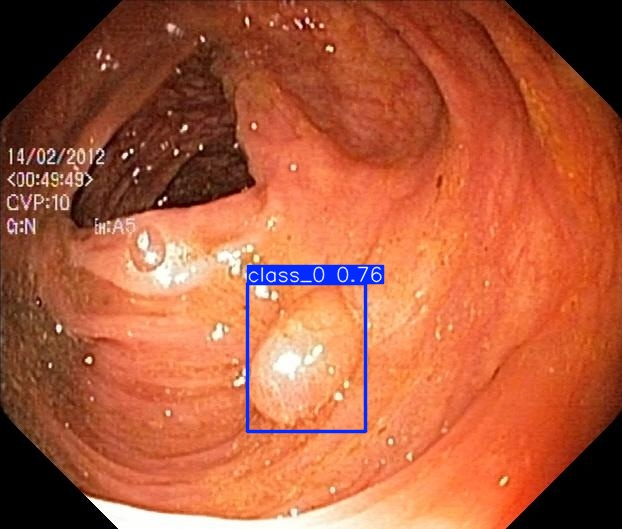

In [31]:
Image.open("runs/detect/predict/cju1c8ffau5770835g0g343o8.jpg")

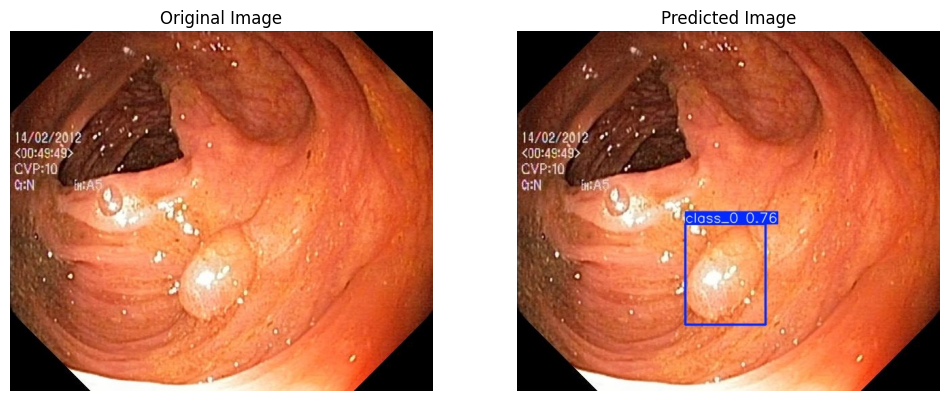

In [33]:

original_image = Image.open("cju1c8ffau5770835g0g343o8.jpg")

predicted_image = Image.open("runs/detect/predict/cju1c8ffau5770835g0g343o8.jpg")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))


axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis("off")  


axes[1].imshow(predicted_image)
axes[1].set_title("Predicted Image")
axes[1].axis("off")


plt.show()
